# Split Learning and Label Leakage

In [1]:
import sys
import os

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve, auc

# from utils.utils import NumpyDataset

In [3]:
class NumpyDataset(Dataset):
    """This class allows you to convert numpy.array to torch.Dataset

    Args:
        x (np.array):
        y (np.array):
        transform (torch.transform):

    Attriutes
        x (np.array):
        y (np.array):
        transform (torch.transform):
    """

    def __init__(self, x, y=None, transform=None, return_idx=False):
        self.x = x
        self.y = y
        self.transform = transform
        self.return_idx = return_idx

    def __getitem__(self, index):
        x = self.x[index]
        if self.y is not None:
            y = self.y[index]

        if self.transform is not None:
            x = self.transform(x)

        if not self.return_idx:
            if self.y is not None:
                return x, y
            else:
                return x
        else:
            if self.y is not None:
                return index, x, y
            else:
                return index, x

    def __len__(self):
        """get the number of rows of self.x"""
        return len(self.x)

In [4]:
class FirstNet(nn.Module):
    def __init__(self, train_features, hidden_dim):
        super(FirstNet, self).__init__()
        self.L1 = nn.Linear(train_features.shape[-1], hidden_dim)

    def forward(self, x):
        x = self.L1(x)
        x = nn.functional.relu(x)
        return x


class SecondNet(nn.Module):
    def __init__(self, hidden_dim):
        super(SecondNet, self).__init__()
        self.L2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.L2(x)
        x = torch.sigmoid(x)
        return x
    
class SurrogateNet(nn.Module):
    def __init__(self, hidden_dim):
        super(SurrogateNet, self).__init__()
        self.L2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.L2(x)
        # x = torch.sigmoid(x)
        return x

## Parameters and Pre-processing

In [5]:
batch_size = 512
hidden_dim = 16
torch.manual_seed(10)

In [6]:
# raw_df = pd.read_csv(
#     "creditcard.csv"
# )
raw_df = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
)
raw_df_neg = raw_df[raw_df["Class"] == 0]
raw_df_pos = raw_df[raw_df["Class"] == 1]

down_df_neg = raw_df_neg  # .sample(40000)
down_df = pd.concat([down_df_neg, raw_df_pos])

neg, pos = np.bincount(down_df["Class"])
total = neg + pos
print(
    "Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n".format(
        total, pos, 100 * pos / total
    )
)

sample_num = total

cleaned_df = down_df.copy()
# You don't want the `Time` column.
cleaned_df.pop("Time")
# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001  # 0 => 0.1¢
cleaned_df["Log Ammount"] = np.log(cleaned_df.pop("Amount") + eps)

cleaned_df


Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Ammount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,1,5.966149
280143,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,1,-0.273122
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,1,4.355310
281144,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,1,5.501262


In [7]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop("Class"))
test_labels = np.array(test_df.pop("Class"))

train_features = np.array(train_df)
test_features = np.array(test_df)

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
train_features = np.clip(train_features, -5, 5)

test_features = scaler.fit_transform(test_features)
test_features = np.clip(test_features, -5, 5)

train_dataset = NumpyDataset(
    train_features, train_labels.astype(np.float64).reshape(-1, 1)
)
test_dataset = NumpyDataset(
    test_features, test_labels.astype(np.float64).reshape(-1, 1)
)


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

## Split Learning training

In [8]:
client_model = FirstNet(train_features, hidden_dim)
server_model = SecondNet(hidden_dim)

client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
server_optimizer = torch.optim.Adam(server_model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [9]:
client_model, server_model

(FirstNet(
   (L1): Linear(in_features=29, out_features=16, bias=True)
 ),
 SecondNet(
   (L2): Linear(in_features=16, out_features=1, bias=True)
 ))

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialization
num_epochs = 10
train_acc_list = []
train_loss_list = []
all_labels = []
all_predictions = []

# Save grads, p_hats for training surrogate model use
grads = []
embeddings = []
ys = []
exp_path = f"./exp"
for epoch in range(num_epochs):
    client_model.train()
    server_model.train()
    correct = 0
    total = 0
    total_loss = 0
    
    for features, labels in train_loader:
        features = features.float()
        labels = labels.float()

        batch_size = features.shape[0]
        # Client side
        client_optimizer.zero_grad()
        intermediate_features = client_model(features)
        
        intermediate_features.retain_grad()
        # Send to server
        server_optimizer.zero_grad()
        outputs = server_model(intermediate_features)

        loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)
        

        grad = intermediate_features.grad.detach()
        embeddings.append(intermediate_features.detach().cpu())
        grads.append(grad.detach().cpu() * batch_size)
        ys.append(labels.cpu())
        # Update both server and client models
        server_optimizer.step()
        client_optimizer.step()

        # Update accuracy and loss stats
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

        # Store outputs for ROC computation
        all_labels.extend(labels.cpu().detach().numpy())
        all_predictions.extend(outputs.cpu().detach().numpy())
        
    # Calculate and store average accuracy and loss for each epoch
    epoch_acc = correct / total
    epoch_loss = total_loss / len(train_loader)
    train_acc_list.append(epoch_acc)
    train_loss_list.append(epoch_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%")



    save_path = f"{exp_path}/"

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    if epoch == (num_epochs-1):
        grads = torch.cat(grads).numpy()
        embeddings = torch.cat(embeddings).numpy()

        ys = torch.cat(ys).numpy()
        np.savez(f"{save_path}/grads.npz", embeddings=embeddings, ys=ys, grads=grads)
        torch.save(client_model.state_dict(), f"{save_path}/client_model.pt")
        torch.save(server_model.state_dict(), f"{save_path}/server_model.pt")
    grads = []
    embeddings = []
    ys = []

Epoch 1/10, Loss: 0.1461, Accuracy: 99.82%
Epoch 2/10, Loss: 0.0115, Accuracy: 99.91%
Epoch 3/10, Loss: 0.0056, Accuracy: 99.93%
Epoch 4/10, Loss: 0.0042, Accuracy: 99.94%
Epoch 5/10, Loss: 0.0036, Accuracy: 99.94%
Epoch 6/10, Loss: 0.0033, Accuracy: 99.94%
Epoch 7/10, Loss: 0.0031, Accuracy: 99.94%
Epoch 8/10, Loss: 0.0030, Accuracy: 99.94%
Epoch 9/10, Loss: 0.0029, Accuracy: 99.94%
Epoch 10/10, Loss: 0.0028, Accuracy: 99.95%


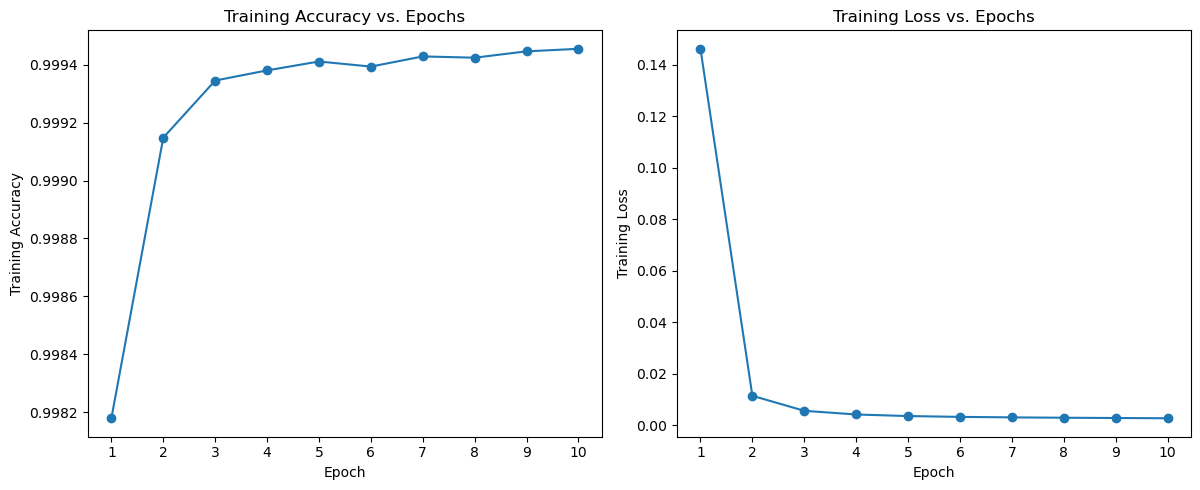

In [11]:
# Plot acc-epoch and loss-epoch graphs
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_acc_list, '-o')
plt.title('Training Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.xticks(range(1, num_epochs + 1))

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), train_loss_list, '-o')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks(range(1, num_epochs + 1))

plt.tight_layout()
plt.show()

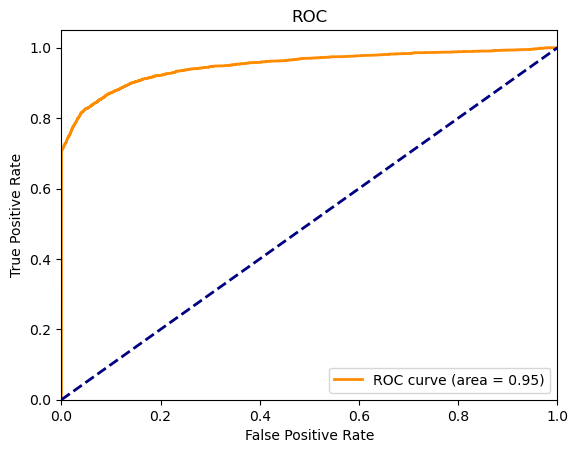

In [12]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

In [13]:
# Put the models in evaluation mode
client_model.eval()
server_model.eval()

correct = 0
total = 0
test_labels = []
test_predictions = []

# Get predictions on test set
for features, labels in test_loader:
    features = features.float()
    labels = labels.float()

    intermediate_features = client_model(features)
    outputs = server_model(intermediate_features)

    predicted = (outputs > 0.5).float()  # Assuming binary classification
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    test_labels.extend(labels.cpu().detach().numpy())
    test_predictions.extend(outputs.cpu().detach().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute ROC curve and ROC area for test set
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
roc_auc = auc(fpr, tpr)

Test Accuracy: 99.95%


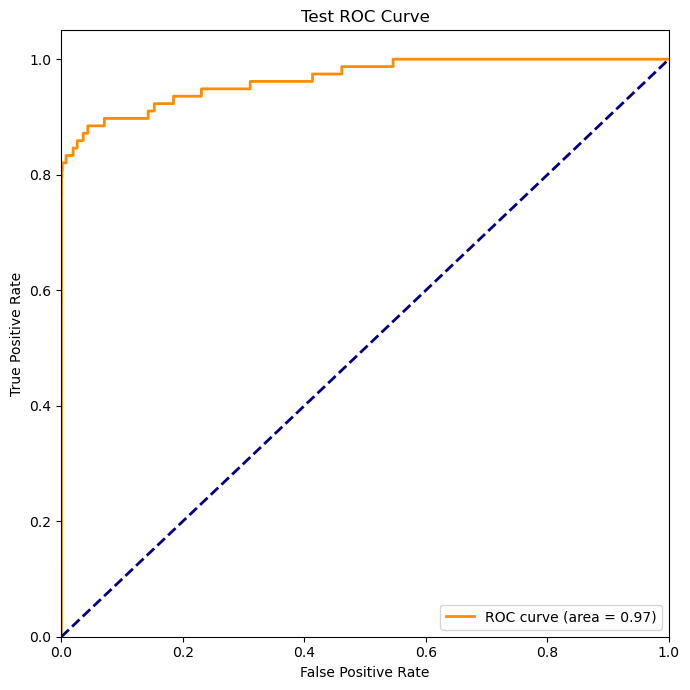

In [14]:
# Plotting ROC curve for test set
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## ExPloit Attack

In [15]:
surrogate_model = SurrogateNet(hidden_dim)

grad_data = np.load(exp_path + "/grads.npz")
embeddings, grads, labels = (
    torch.tensor(grad_data["embeddings"]),
    torch.tensor(grad_data["grads"]),
    torch.tensor(grad_data["ys"]),
)

In [16]:
surrogate_model

SurrogateNet(
  (L2): Linear(in_features=16, out_features=2, bias=True)
)

In [17]:
indices = torch.arange(embeddings.shape[0]).long()
batch_size = 512

ds = torch.utils.data.TensorDataset(indices, embeddings, grads, labels)
dl = torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
)
ys_logits = (
    torch.zeros(grads.shape[0], 2)
    .requires_grad_(True)
)

In [18]:
opt_model = torch.optim.Adam(
    surrogate_model.parameters(),
    lr=0.002
)
opt_y = torch.optim.Adam(
    [ys_logits],
    lr=0.02
)

In [19]:
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
class KlDivLoss(_Loss):
    __constants__ = ["reduction"]

    def __init__(
        self,
        size_average=None,
        reduce=None,
        reduction: str = "mean",
        logits: bool = True,
    ) -> None:
        super(KlDivLoss, self).__init__(size_average, reduce, reduction)
        self.logits = logits
        self.eps = 1e-12

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:

        if self.logits:
            pred = torch.softmax(pred, dim=-1)

        loss = (-target * torch.log((pred / (target + self.eps)) + self.eps)).sum(
            dim=-1
        )

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction is None:
            return loss
        else:
            sys.exit(f"Invalid reduction type: {self.reduction}")


class SoftCrossEntropyLoss(_Loss):
    __constants__ = ["reduction"]

    def __init__(
        self,
        size_average=None,
        reduce=None,
        reduction: str = "mean",
        logits: bool = True,
    ) -> None:
        super(SoftCrossEntropyLoss, self).__init__(size_average, reduce, reduction)
        self.logits = logits
        self.eps = 1e-12

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:

        if self.logits:
            loss = (-target * torch.log_softmax(pred, dim=-1)).sum(dim=-1)
        else:
            loss = (-target * torch.log(pred + self.eps)).sum(dim=-1)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction is None:
            return loss
        else:
            sys.exit(f"Invalid reduction type: {self.reduction}")


class EntropyLoss(_Loss):
    def __init__(self, logits=True, reduction="mean"):
        super(EntropyLoss, self).__init__()
        self.logits = logits
        self.eps = 1e-12
        self.reduction = reduction

    def forward(self, x):
        if self.logits:
            loss = -(F.softmax(x, dim=1) * F.log_softmax(x, dim=1)).sum(dim=-1)
        else:
            loss = -(x * torch.log(x + self.eps)).sum(dim=-1)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction is None:
            return loss
        else:
            sys.exit(f"Invalid reduction type: {self.reduction}")

In [20]:
def get_accuracy(true_labels, pred_labels):
    true_labels = true_labels.detach().cpu().numpy()
    pred_labels = pred_labels.unsqueeze(-1).detach().cpu().numpy()
    pred_labels_mapped = np.ones_like(pred_labels) * -1
    n_classes = 1
    for i in reversed(range(n_classes + 1)):
        label_map = np.bincount(pred_labels[true_labels == i]).argmax()
        pred_labels_mapped[pred_labels == label_map] = i
    return (pred_labels_mapped == true_labels).astype(float).mean()

In [21]:
ys_prior = torch.ones([1, 2]) / 2
mean_norm = grads.norm(dim=-1).mean().detach().item()
n_classes = 2
p = 1 - pos / sample_num
H_y = -p * np.log(p) - (1 - p) * np.log(1 - p)
print(p)
print(H_y)

0.9982725143693799
0.01271468133593648


In [22]:
from tqdm import tqdm
attack_epochs = 20
lamb_grad = 1
lamb_acc = 1.5
lamb_lp = 1
criterion_ce_soft = SoftCrossEntropyLoss(reduction="mean")
criterion_kl = KlDivLoss(reduction="mean")
criterion_entropy =EntropyLoss(logits=False)

(
    grad_loss_list_all,
    acc_loss_list_all,
    loss_opt_list_all,
    lp_loss_list_all,
    acc_list_all,
) = ([], [], [], [], [])


for epoch in range(attack_epochs):
    surrogate_model.train()
    (
        grad_loss_list,
        acc_loss_list,
        loss_opt_list,
        lp_loss_list,
    ) = ([], [], [], [])
    for index, p_hat, grad, label in tqdm(
        dl, leave=False
    ):
        batch_size = grad.shape[0]
        p_hat.requires_grad = True
        opt_model.zero_grad()
        opt_y.zero_grad()
        ys = torch.softmax(ys_logits, dim=-1)
        y = ys[index]

        p = surrogate_model(p_hat)
        H_label = criterion_entropy(y)

        ce_loss = criterion_ce_soft(p, y)
        grad_approx = torch.autograd.grad(ce_loss, p_hat, create_graph=True)[0]
        grad_loss = (
            (grad - grad_approx * batch_size).norm(dim=-1)
        ).mean() / mean_norm

        acc_loss = ce_loss / H_y

        ys_mean = ys.mean(dim=0, keepdims=True)
        lp_loss = criterion_kl(ys_prior, ys_mean)
        ys_labels = torch.argmax(ys, dim=-1).detach().cpu()
        loss = (
            lamb_grad * grad_loss
            + lamb_acc * acc_loss
            + lamb_lp * lp_loss
        )

        loss_opt = grad_loss + acc_loss + lp_loss
        loss.backward()

        opt_model.step()
        opt_y.step()
        
        grad_loss_list.append(grad_loss.detach().cpu().item())
        acc_loss_list.append(acc_loss.detach().cpu().item())
        lp_loss_list.append(lp_loss.detach().cpu().item())
        loss_opt_list.append(loss_opt.detach().cpu().item())
        
    loss_opt_list_all.append(np.mean(loss_opt_list))
    grad_loss_list_all.append(np.mean(grad_loss_list))
    acc_loss_list_all.append(np.mean(acc_loss_list))
    lp_loss_list_all.append(np.mean(lp_loss_list))

    acc = get_accuracy(labels.clone(), ys_labels.clone()) * 100
    acc_list_all.append(acc)

    print(f"epoch {epoch}-acc:{acc} loss:{np.mean(loss_opt_list)}")
    

epoch 0-acc:51.97085738111436 loss:61.11494027552583


epoch 1-acc:53.72336456801773 loss:55.67181555572647


epoch 2-acc:70.3702078167175 loss:55.50448419374201


epoch 3-acc:97.86302091334021 loss:54.033349768463275


epoch 4-acc:99.71340165463364 loss:43.850233266171855


epoch 5-acc:99.78845267616143 loss:28.13648764862608


epoch 6-acc:99.8103974192982 loss:17.019967258778387


epoch 7-acc:99.8165419473765 loss:11.195367451740488


epoch 8-acc:99.81785863196471 loss:8.079429221260174


epoch 9-acc:99.81829752682745 loss:6.212754474092492


epoch 10-acc:99.81829752682745 loss:5.005686521530151


epoch 11-acc:99.81829752682745 loss:4.178403586550144


epoch 12-acc:99.81829752682745 loss:3.5872164087979783


epoch 13-acc:99.81829752682745 loss:3.1470028044396985


epoch 14-acc:99.81829752682745 loss:2.8171822126670802


epoch 15-acc:99.81829752682745 loss:2.564698537636231


epoch 16-acc:99.81829752682745 loss:2.3681405245455927


epoch 17-acc:99.81829752682745 loss:2.2150033950271095


epoch 18-acc:99.81829752682745 loss:2.0927483837700747


epoch 19-acc:99.81829752682745 loss:1.9952791311815714


In [23]:
print(loss_opt_list_all)
print(acc_list_all)

[61.11494027552583, 55.67181555572647, 55.50448419374201, 54.033349768463275, 43.850233266171855, 28.13648764862608, 17.019967258778387, 11.195367451740488, 8.079429221260174, 6.212754474092492, 5.005686521530151, 4.178403586550144, 3.5872164087979783, 3.1470028044396985, 2.8171822126670802, 2.564698537636231, 2.3681405245455927, 2.2150033950271095, 2.0927483837700747, 1.9952791311815714]
[51.97085738111436, 53.72336456801773, 70.3702078167175, 97.86302091334021, 99.71340165463364, 99.78845267616143, 99.8103974192982, 99.8165419473765, 99.81785863196471, 99.81829752682745, 99.81829752682745, 99.81829752682745, 99.81829752682745, 99.81829752682745, 99.81829752682745, 99.81829752682745, 99.81829752682745, 99.81829752682745, 99.81829752682745, 99.81829752682745]


([<matplotlib.axis.XTick at 0x7f783b282910>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

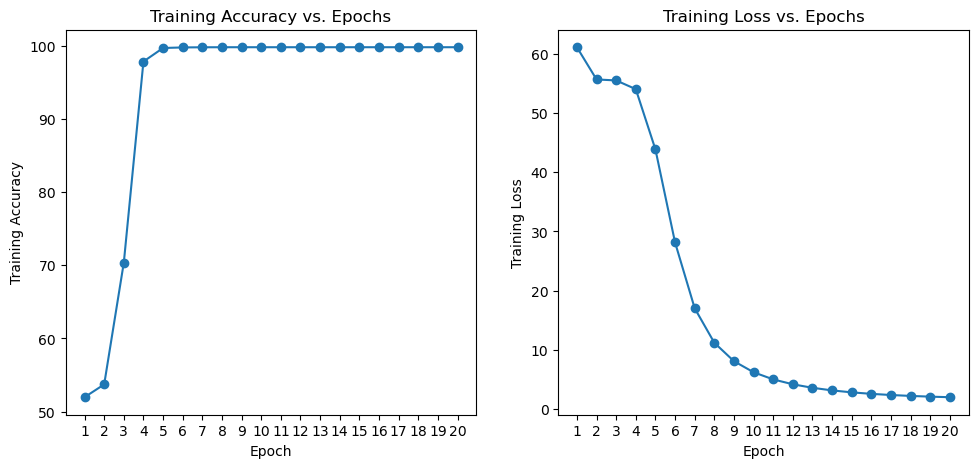

In [24]:
# Plot acc-epoch and loss-epoch graphs
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, attack_epochs + 1), acc_list_all, '-o')
plt.title('Training Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.xticks(range(1, attack_epochs + 1))

plt.subplot(1, 3, 2)
plt.plot(range(1, attack_epochs + 1), loss_opt_list_all, '-o')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks(range(1, attack_epochs + 1))

In [25]:
# Put the models in evaluation mode
client_model.eval()
surrogate_model.eval()

correct = 0
total = 0
test_labels = []
test_predictions = []
import torch

# Get predictions on test set
for features, labels in test_loader:
    features = features.float()
    labels = labels.float()

    intermediate_features = client_model(features)
    outputs = surrogate_model(intermediate_features)
    probabilities = torch.softmax(outputs, dim=1)
    predicted = 1 - torch.argmax(probabilities, dim=1).float()
    total += labels.size(0)
    correct += (predicted == labels.view(-1)).sum().item()

    test_labels.extend(labels.cpu().detach().numpy())
    test_predictions.extend(predicted.cpu().detach().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute ROC curve and ROC area for test set
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
roc_auc = auc(fpr, tpr)
print(roc_auc)

Test Accuracy: 0.14%
0.5


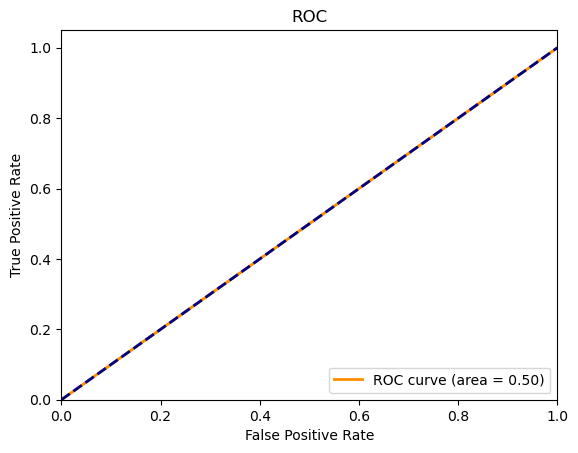

In [26]:
# Compute ROC curve and ROC area
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()